In [50]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.bands import *
from util.pairs_selection import *
from util.backtest import *
import matplotlib.ticker as ticker
plt.rcParams["font.family"] = "NanumGothic"
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings(action='ignore')

# 페어 선정 없는 버전

# Data load
pairs_list = [#('CJ', 'CJ4우(전환)'),
 ('CJ', 'CJ우'),
 ('CJ제일제당', 'CJ제일제당 우'),
 ('DB하이텍', 'DB하이텍1우'),
 #('DL이앤씨', 'DL이앤씨2우(전환)'),
 #('DL이앤씨', 'DL이앤씨우'),
 ('GS', 'GS우'),
 #('JW중외제약', 'JW중외제약2우B'),
 ('JW중외제약', 'JW중외제약우'),
 ('LG', 'LG우'),
 ('LG생활건강', 'LG생활건강우'),
 ('LG전자', 'LG전자우'),
 ('LG화학', 'LG화학우'),
 #('LX하우시스', 'LX하우시스우'),
 ('NH투자증권', 'NH투자증권우'),
 #('SK', 'SK우'),
 ('SK네트웍스', 'SK네트웍스우'),
 ('SK이노베이션', 'SK이노베이션우'),
 ('S-Oil', 'S-Oil우'),
 ('금호석유', '금호석유우'),
 ('넥센타이어', '넥센타이어1우B'),
 ('대상', '대상우'),
 ('대한항공', '대한항공우'),
 #('미래에셋증권', '미래에셋증권2우B'),
 ('미래에셋증권', '미래에셋증권우'),
 ('삼성SDI', '삼성SDI우'),
 #('삼성물산', '삼성물산우B'),
 ('삼성전기', '삼성전기우'),
 ('삼성전자', '삼성전자우'),
 ('삼성화재', '삼성화재우'),
 #('아모레G', '아모레G3우(전환)'),
 ('아모레G', '아모레G우'),
 ('아모레퍼시픽', '아모레퍼시픽우'),
 ('유한양행', '유한양행우'),
 #('하이트진로', '하이트진로2우B'),
 ('한국금융지주', '한국금융지주우'),
 #('한화', '한화3우B'),
 ('한화', '한화우'),
 ('한화솔루션', '한화솔루션우'),
 ('현대건설', '현대건설우'),
 #('현대차', '현대차2우B'),
 #('현대차', '현대차3우B'),
 ('현대차', '현대차우'),
 ('호텔신라', '호텔신라우')]

In [88]:
pairs_list = [('CJ', 'CJ우'),
 ('LG', 'LG우'),
 ('LG생활건강', 'LG생활건강우'),
 ('LG전자', 'LG전자우'),
 ('LG화학', 'LG화학우'),
 ('NH투자증권', 'NH투자증권우'),
 ('SK이노베이션', 'SK이노베이션우'),
 ('S-Oil', 'S-Oil우'),
 ('미래에셋증권', '미래에셋증권우'),
 ('삼성SDI', '삼성SDI우'),
 ('삼성전자', '삼성전자우'),
 ('삼성화재', '삼성화재우'),
 ('아모레퍼시픽', '아모레퍼시픽우'),
 ('한국금융지주', '한국금융지주우'),
 ('현대차', '현대차우')]

In [3]:
main_path = '/home/lululalamoon/CHO/chosta/data/k_stocks/daily/ohlcv'
ohlcv_list = []
price_pairs = []
stock_names = []
for pair in pairs_list:
    for j in pair:
        data = pd.read_csv(main_path + f'/{j}_ohlcv.csv', index_col=0, parse_dates=True)
        ohlcv_list.append(data)
        stock_names.append(j)
ohlcv_dict = dict(zip(stock_names, ohlcv_list))

all_transactions = []
all_inventories = []
opt_window_list = []
max_pnl_list = []

for i in range(len(pairs_list)):

    common = pairs_list[i][0]
    preferred = pairs_list[i][1]

    common_price = ohlcv_dict[common]['종가'].rename(common)  # 수정종가 사용
    preferred_price = ohlcv_dict[preferred]['종가'].rename(preferred)
    pairs_prices = pd.concat([common_price, preferred_price], axis=1)

    # get spread
    first = pairs_prices.dropna().iloc[:, 0]  # 보통주
    second = pairs_prices.dropna().iloc[:, 1]  # 우선주
    spread = get_log_spread(first, second)  # lny-lnx

    last_invens = []
    windows = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    for win in windows:
        # make bands
        window = win
        mult = 2
        mult2 = 2.5
        df_bb = bollinger_bands_double(spread, window, mult, mult2).dropna()

        sp, lb, ub, ma = df_bb.price, df_bb.lb, df_bb.ub, df_bb.MA
        lb2, ub2 = df_bb.lb2, df_bb.ub2

        # trade_dates = get_trade_dates_bbd_m(sp, ub, lb, ub2, lb2, ma)
        # trade_dates = get_trade_dates_bbd_m_long(sp, ub, lb, ub2, lb2, ma)
        # trade_dates = get_trade_dates_bb_m_long(sp, lb, ma)
        # trade_dates = get_trade_dates_bb_long(sp, ub, lb)
        trade_dates = get_trade_dates_bbd_long(sp, ub, lb, ub2, lb2)

        initial_invest = 100_000_000
        c = 0.002  # 거래당
        transactions_list = []

        inventory_now = initial_invest
        inventory_history = [inventory_now]

        trade_dates_is = trade_dates.loc[(trade_dates.entry > '2009-1-1') & (trade_dates.entry < '2017-1-1')] # in-sample

        for t in trade_dates_is.index:  # t는 하나의 round-trip
            entry = pd.to_datetime(trade_dates_is.entry[t])
            exit = pd.to_datetime(trade_dates_is.exit[t])

            pos = trade_dates_is.position[t]

            p1_in = first[entry]
            p2_in = second[entry]
            p1_out = first[exit]
            p2_out = second[exit]
            q1 = int(inventory_now / (2 * p1_in))
            q2 = int(inventory_now / (2 * p2_in))

            one_transaction = [[entry, -pos * q1, p1_in, common],
                               [entry, pos * q2, p2_in, preferred],
                               [exit, pos * q1, p1_out, common],
                               [exit, -pos * q2, p2_out, preferred]]
            one_transaction = pd.DataFrame(one_transaction, columns=['index', 'amount', 'price', 'symbol']).set_index(
                'index')

            pnl1_ = (-pos) * (q1 * p1_out - q1 * p1_in)
            cost1_ = c * (q1 * p1_out + q1 * p1_in)
            pnl2_ = pos * (q2 * p2_out - q2 * p2_in)
            cost2_ = c * (q2 * p2_out + q2 * p2_in)

            pnl1 = pnl1_ - cost1_
            pnl2 = pnl2_ - cost2_

            inventory_now += (pnl1 + pnl2)
            inventory_history.append(inventory_now)
            transactions_list.append(one_transaction)

        transactions = pd.concat(transactions_list)

        ind_ = [list(trade_dates_is.entry)[0]] + list(trade_dates_is.exit)
        inventory = pd.Series(inventory_history, index=pd.to_datetime(ind_))
        inventory = inventory.resample('D').last().ffill()
        inventory = inventory.to_frame().rename(
            columns={0: common + ' & ' + preferred})

        if np.any(inventory <= 0):
            from_ind_ = inventory[inventory.iloc[:, 0] <= 0].index[0]
            inventory.loc[from_ind_:, :] = 0

        last_invens.append(inventory.iloc[-1, 0])
    opt_window = windows[np.argmax(np.array(last_invens))]
    opt_window_list.append(opt_window)
    
    all_inventories.append(inventory)
    max_pnl = np.max(np.array(last_invens))
    max_pnl_list.append(max_pnl)
    
    print(common, '&', preferred, "'s Optimal window: ", opt_window)
    

CJ & CJ우 's Optimal window:  10
LG & LG우 's Optimal window:  20
LG생활건강 & LG생활건강우 's Optimal window:  10
LG전자 & LG전자우 's Optimal window:  10
LG화학 & LG화학우 's Optimal window:  20
NH투자증권 & NH투자증권우 's Optimal window:  50
SK이노베이션 & SK이노베이션우 's Optimal window:  20
S-Oil & S-Oil우 's Optimal window:  60
미래에셋증권 & 미래에셋증권우 's Optimal window:  10
삼성SDI & 삼성SDI우 's Optimal window:  60
삼성전자 & 삼성전자우 's Optimal window:  10
삼성화재 & 삼성화재우 's Optimal window:  10
아모레퍼시픽 & 아모레퍼시픽우 's Optimal window:  25
한국금융지주 & 한국금융지주우 's Optimal window:  15
현대차 & 현대차우 's Optimal window:  30


In [4]:
rets = pd.concat(all_inventories,axis=1).pct_change().replace(0,np.nan)

In [5]:
rets.iloc[:,i].dropna().resample('Y').count().mean()

1.6666666666666667

In [6]:
srdf = pd.DataFrame(index=['ASR'])
for i in range(len(rets.T)):
    sr = (rets.iloc[:,i].dropna().mean() / rets.iloc[:,i].dropna().std()) * np.sqrt(rets.iloc[:,i].dropna().resample('Y').count().mean())
    srdf[rets.columns[i]] = sr

In [7]:
opt_dict = dict(zip(pairs_list, opt_window_list))
maxpnl_dict = dict(zip(pairs_list, max_pnl_list))

In [8]:
df = pd.DataFrame(opt_dict, index=['optimal windows']).T

In [9]:
commons = [df.index[i][0] for i in range(len(df))]
preferreds = [df.index[i][1] for i in range(len(df))]

In [10]:
# 가격 변동성 이용
보통주변동성 = np.array([ohlcv_dict[i].종가['2009-1':'2016-12'].pct_change().std() for i in commons])
우선주변동성 = np.array([ohlcv_dict[i].종가['2009-1':'2016-12'].pct_change().std() for i in preferreds])

df['보통주 수익률 변동성'] = 보통주변동성.round(4)
df['우선주 수익률 변동성'] = 우선주변동성.round(4)

In [11]:
# 거래량 이용

보통주거래량 = np.array([ohlcv_dict[i].거래량['2009-1':'2016-12'].mean() for i in commons])
우선주거래량 = np.array([ohlcv_dict[i].거래량['2009-1':'2016-12'].mean() for i in preferreds])

df['보통주 평균 거래량'] = 보통주거래량.round(2)
df['우선주 평균 거래량'] = 우선주거래량.round(2)

In [12]:
from pykrx import stock
tickers = stock.get_market_ticker_list()
names = []
for ticker in tickers:
    name = stock.get_market_ticker_name(ticker)
    names.append(name)
ticker_dict = dict(zip(names, tickers))

In [13]:
common_tickers = [ticker_dict[i] for i in commons]
preferred_tickers = [ticker_dict[i] for i in preferreds]

In [14]:
mc = stock.get_market_cap("20140103")
보통주시가총액 = np.array(mc['시가총액'].loc[common_tickers])
우선주시가총액 = np.array(mc['시가총액'].loc[preferred_tickers])

df['보통주 시가총액'] = 보통주시가총액
df['우선주 시가총액'] = 우선주시가총액

In [15]:
df['PNL cumsum'] = np.array(max_pnl_list).round() - 100_000_000

In [16]:
df['SR'] = srdf.T.ASR.values

In [17]:
df.sort_values('SR')

,,optimal windows,보통주 수익률 변동성,우선주 수익률 변동성,보통주 평균 거래량,우선주 평균 거래량,보통주 시가총액,우선주 시가총액,PNL cumsum,SR
LG,LG우,20,0.0207,0.0174,484461.11,4607.15,10646774982700,123471718250,34431767.0,-0.041109
CJ,CJ우,10,0.0236,0.0192,139731.17,7513.45,3397746924000,90973975750,48326055.0,-0.004039
S-Oil,S-Oil우,60,0.0233,0.0131,379991.36,8408.85,8004636511200,205922662400,-293169.0,0.031363
LG전자,LG전자우,10,0.0212,0.0204,1094417.96,55230.76,10817120505400,435664897200,18453910.0,0.081533
현대차,현대차우,30,0.0219,0.0218,858917.64,72018.31,49341931296000,2925312903000,57009471.0,0.090345
LG생활건강,LG생활건강우,10,0.0220,0.0206,46623.69,4625.62,8371353592000,469282279500,132416545.0,0.139500
SK이노베이션,SK이노베이션우,20,0.0247,0.0164,519828.52,5398.35,12806480614000,78401152800,32814977.0,0.369525
NH투자증권,NH투자증권우,50,0.0245,0.0150,1242674.47,48121.52,1884941543980,85579839880,32513567.0,0.392960
LG화학,LG화학우,20,0.0241,0.0232,337788.35,30219.87,18953534600000,1136709229000,63419564.0,0.413823
삼성SDI,삼성SDI우,60,0.0242,0.0206,418624.80,8185.21,6993205343500,110340507200,21998140.0,0.420114


In [18]:
df_rank = df.iloc[:,0].to_frame().join(df.iloc[:,1:].rank(method='min', ascending=False)).sort_values('optimal windows')

In [19]:
df_rank.sort_values('우선주 시가총액')

,,optimal windows,보통주 수익률 변동성,우선주 수익률 변동성,보통주 평균 거래량,우선주 평균 거래량,보통주 시가총액,우선주 시가총액,PNL cumsum,SR
삼성전자,삼성전자우,10,15.0,8.0,10.0,5.0,1.0,1.0,6.0,2.0
현대차,현대차우,30,10.0,2.0,4.0,1.0,2.0,2.0,5.0,11.0
LG화학,LG화학우,20,6.0,1.0,9.0,6.0,3.0,3.0,3.0,7.0
삼성화재,삼성화재우,10,14.0,13.0,13.0,15.0,5.0,4.0,8.0,4.0
LG생활건강,LG생활건강우,10,9.0,3.0,14.0,13.0,8.0,5.0,2.0,10.0
아모레퍼시픽,아모레퍼시픽우,25,13.0,5.0,15.0,11.0,11.0,6.0,1.0,5.0
LG전자,LG전자우,10,11.0,5.0,3.0,2.0,6.0,7.0,14.0,12.0
S-Oil,S-Oil우,60,8.0,15.0,8.0,8.0,9.0,8.0,15.0,13.0
LG,LG우,20,12.0,10.0,6.0,14.0,7.0,9.0,10.0,15.0
삼성SDI,삼성SDI우,60,5.0,3.0,7.0,9.0,10.0,10.0,13.0,6.0


In [20]:
df_rank.sort_values('PNL cumsum').index

MultiIndex([( '아모레퍼시픽',  '아모레퍼시픽우'),
            ( 'LG생활건강',  'LG생활건강우'),
            (   'LG화학',    'LG화학우'),
            ( '한국금융지주',  '한국금융지주우'),
            (    '현대차',     '현대차우'),
            (   '삼성전자',    '삼성전자우'),
            ( '미래에셋증권',  '미래에셋증권우'),
            (   '삼성화재',    '삼성화재우'),
            (     'CJ',      'CJ우'),
            (     'LG',      'LG우'),
            ('SK이노베이션', 'SK이노베이션우'),
            ( 'NH투자증권',  'NH투자증권우'),
            (  '삼성SDI',   '삼성SDI우'),
            (   'LG전자',    'LG전자우'),
            (  'S-Oil',   'S-Oil우')],
           )

In [21]:
np.array(inventory_history)

array([1.00000000e+08, 1.09379507e+08, 1.08055739e+08, 1.01935614e+08,
       1.01040758e+08, 9.85565560e+07, 9.96506138e+07, 9.72941186e+07,
       9.65136806e+07, 9.89286818e+07, 9.65913788e+07, 9.67743868e+07,
       1.03386900e+08, 1.06636881e+08, 1.05418020e+08, 1.03082763e+08])

In [99]:
date_list = ["20090105","20110105","20130103","20150105","20170103","20190103","20210105"]
dfdf = pd.DataFrame(index=preferreds)
for d in date_list:
    mc = stock.get_market_cap(d)
    우선주시가총액 = np.array(mc['시가총액'].loc[preferred_tickers])
    dfdf[f'{d}'] = 우선주시가총액

In [100]:
dfdf = dfdf.reset_index(drop=True)

In [101]:
dfdf

,20090105,20110105,20130103,20150105,20170103,20190103,20210105
0,33790333850,63512266300,61026021000,178557617000,166804457400,113237172300,131318956300
1,55852307450,106732599400,77397707950,134244418500,129769604550,133250015400,232027390000
2,90181986150,194221972500,388443945000,566918190000,1079244258000,1408896687000,1486585476000
3,570574934400,750168550800,370358127600,468318282000,452850889200,437383496400,1201300840800
4,260703655100,1296916570000,816294547000,1010832032500,1323617793500,1433961200000,3029387200000
5,123793550080,182482260560,90486291560,110206453120,124548388800,159459679600,161346776400
6,39824789400,78650838000,63669726000,62296457400,110735386200,137951073000,227213532000
7,181791100400,211151167500,236087114900,122668773500,225227912000,257403328000,156452960300
8,75727535000,140757500000,65663373750,72067840000,78401927500,55388076250,70167613750
9,39962031200,112120192800,80571220800,113899878400,87528173600,134285368000,581633612000


In [253]:
top_pairs_list=[]
for i in range(len(dfdf.T)):
    top_list = list(dfdf.sort_values(dfdf.columns[i], ascending=False).index[:5])
    top_pairs = [pairs_list[j] for j in top_list]
    top_pairs_list.append(top_pairs)

In [254]:
top_pairs_list

[[('삼성전자', '삼성전자우'),
  ('LG전자', 'LG전자우'),
  ('현대차', '현대차우'),
  ('LG화학', 'LG화학우'),
  ('삼성화재', '삼성화재우')],
 [('삼성전자', '삼성전자우'),
  ('현대차', '현대차우'),
  ('LG화학', 'LG화학우'),
  ('LG전자', 'LG전자우'),
  ('아모레퍼시픽', '아모레퍼시픽우')],
 [('삼성전자', '삼성전자우'),
  ('현대차', '현대차우'),
  ('LG화학', 'LG화학우'),
  ('아모레퍼시픽', '아모레퍼시픽우'),
  ('LG생활건강', 'LG생활건강우')],
 [('삼성전자', '삼성전자우'),
  ('현대차', '현대차우'),
  ('아모레퍼시픽', '아모레퍼시픽우'),
  ('LG화학', 'LG화학우'),
  ('LG생활건강', 'LG생활건강우')],
 [('삼성전자', '삼성전자우'),
  ('현대차', '현대차우'),
  ('아모레퍼시픽', '아모레퍼시픽우'),
  ('LG화학', 'LG화학우'),
  ('LG생활건강', 'LG생활건강우')],
 [('삼성전자', '삼성전자우'),
  ('현대차', '현대차우'),
  ('LG화학', 'LG화학우'),
  ('LG생활건강', 'LG생활건강우'),
  ('아모레퍼시픽', '아모레퍼시픽우')],
 [('삼성전자', '삼성전자우'),
  ('LG화학', 'LG화학우'),
  ('현대차', '현대차우'),
  ('LG생활건강', 'LG생활건강우'),
  ('LG전자', 'LG전자우')]]

In [255]:
top_pairs = pd.DataFrame({'pairs':top_pairs_list}, index=date_list)

In [256]:
reselection_dates = list(top_pairs.index) + [pd.Timestamp(2022,1,1)]

In [262]:
all_transactions_l=[]; all_inventories_l=[]
all_equity_curve_l=[]; all_pos_l=[]
for n in range(len(top_pairs)):
    all_transactions, all_inventories, all_equity_curve, all_pos = get_backtest(top_pairs.iloc[n].pairs, ohlcv_dict, bb_window=20, bb_sl_mult=4,
                                                                                initial_invest=6_00000000, transaction_cost=0.002,
                                                                                start_date=reselection_dates[n], end_date=reselection_dates[n+1])
    all_transactions_l.append(all_transactions)
    all_inventories_l.append(all_inventories)
    all_equity_curve_l.append(all_equity_curve)
    all_pos_l.append(all_pos)

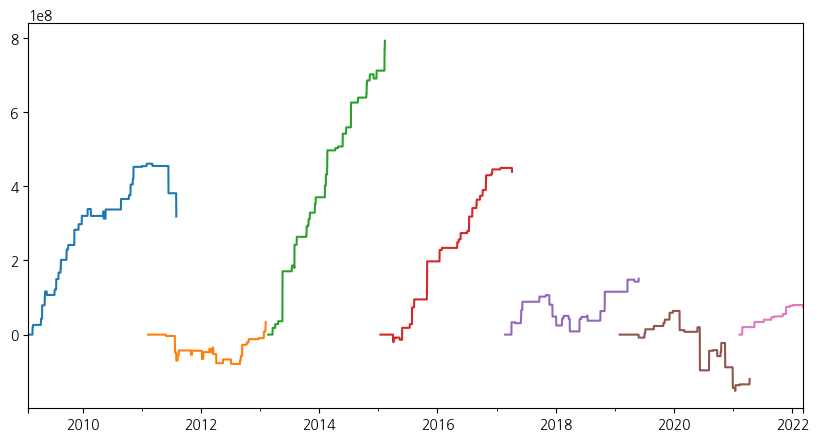

In [263]:
all_inv_sum = []
plt.figure(figsize=(10,5))
for i in range(len(top_pairs)):
    inv_ = pd.concat(all_inventories_l[i],axis=1).fillna(method='ffill').fillna(method='bfill').sum(axis=1)
    inv_.plot()
    all_inv_sum.append(inv_)

In [264]:
inv_sum = pd.concat(all_inv_sum,axis=1).diff().sum(axis=1).cumsum()

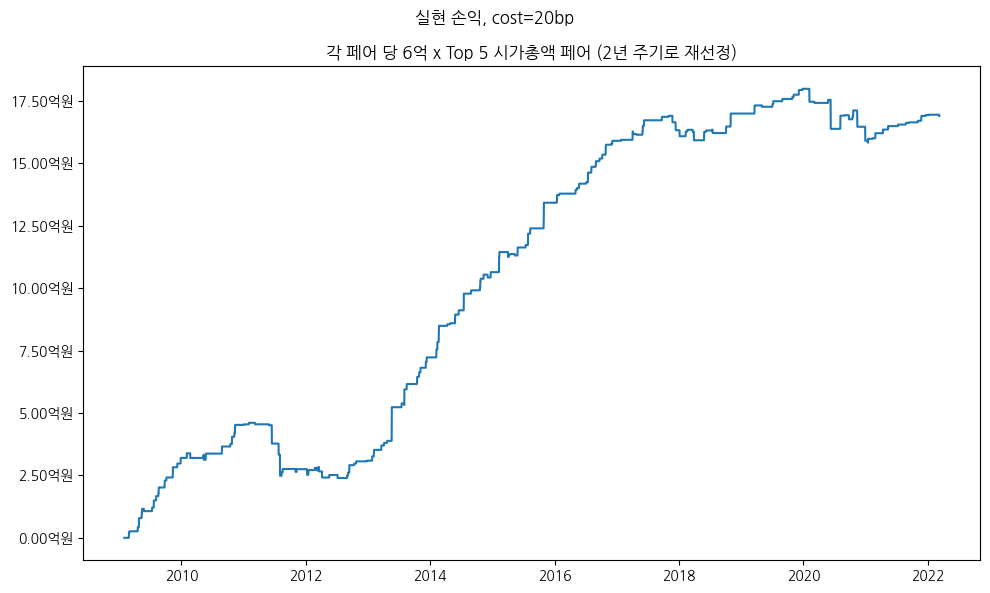

In [267]:
f, ax = plt.subplots(1, figsize=(10, 6))
f.suptitle('실현 손익, cost=20bp')
ax.set_title('각 페어 당 6억 x Top 5 시가총액 페어 (2년 주기로 재선정)')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda inv_sum,
                                pos: '{:,.2f}'.format(inv_sum / 100_000_000) + '억원'))
ax.plot(inv_sum)
f.tight_layout()
plt.show()

In [266]:
(inv_sum[-1]/13)/3_000_000_000

0.043319021629538455

In [232]:
all_eq_sum = []
for i in range(len(top_pairs)):
    eq_ = pd.concat(all_equity_curve_l[i],axis=1).fillna(method='ffill').fillna(method='bfill').sum(axis=1)
    all_eq_sum.append(eq_)

In [160]:
eq_sum = pd.concat(all_eq_sum,axis=1).diff().sum(axis=1).cumsum()[:'2022-1-1']

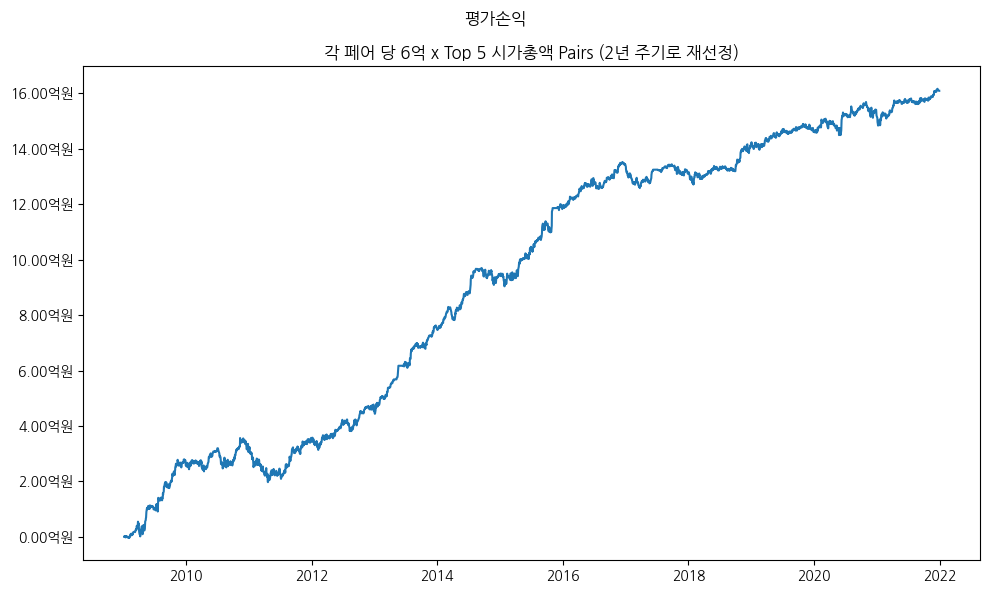

In [161]:
# 전체 자산 평가손익 누적
f, ax = plt.subplots(1, figsize=(10, 6))
f.suptitle('평가손익')
ax.set_title('각 페어 당 6억 x Top 5 시가총액 Pairs (2년 주기로 재선정)')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda eq_sum ,
                                pos: '{:,.2f}'.format(eq_sum  / 100_000_000) + '억원'))
ax.plot(eq_sum )
f.tight_layout()
plt.show()